In [1]:
## -- Check for 3rd party libraries (tpu) --
try:
    import catboost as cgb
except:
    %pip install -q catboost
    import catboost as cgb

In [2]:
!pip show xgboost

Name: xgboost
Version: 3.1.0
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: TPOT


In [3]:
## -- System dependencies --
import sys, os, gc
import torch

## -- Device-Agnostic for GPU --
if torch.cuda.is_available():
    print(f"ℹ️ Device GPU: {torch.cuda.get_device_name(0)}")
    print(f"ℹ️ No. of CPU: {os.cpu_count()} cores")
    # get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    # get_ipython().run_line_magic('load_ext', 'cuml.accel')
    # from cuml.preprocessing import TargetEncoder as cuTE
else:
    print(f"ℹ️ Device: CPU {os.cpu_count()} cores")

ℹ️ Device GPU: Tesla T4
ℹ️ No. of CPU: 4 cores


In [4]:
## -- Data Manipulation --
import numpy as np, pandas as pd, random

## -- Visualization --
from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

## -- Functional Tools --
from time import time, sleep
from tqdm.notebook import tqdm
import itertools

## -- Machine Learning --
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

import warnings

In [5]:
## -- Global Settings --
# sklearn.set_config(transform_output="pandas")
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 1000)
sns.set_style("whitegrid")
# plt.style.use("ggplot")

PALETTE = ['#3A86FF', '#F94144', '#FFBE0B', '#73D2DE', '#FBB13C']
sns.set_palette(PALETTE)

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

## -- Set Global Seed --
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

COLOR = '\033[32m'
RESET = '\033[0m'

In [6]:
## -- Load Data --

PATH = '/kaggle/input/competitions/playground-series-s6e2/'
submit = pd.read_csv(PATH+'sample_submission.csv')
train = pd.read_csv(PATH+"train.csv").drop(['id'], axis=1)
test = pd.read_csv(PATH+"test.csv").drop(['id'], axis=1)

TARGET = train.columns[-1]
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()

ORIG_PATH = '/kaggle/input/datasets/neurocipher/heartdisease/'
orig = pd.read_csv(ORIG_PATH+'Heart_Disease_Prediction.csv')

CATS   = ['Sex', 'Chest pain type', 'FBS over 120', 'EKG results',
          'Exercise angina', 'Slope of ST', 'Number of vessels fluro', 'Thallium'] 
NUMS   = ['Age', 'BP', 'Cholesterol', 'Max HR', 'ST depression']
BASE = NUMS + CATS

for df in [train, orig]:
    df[TARGET] = df[TARGET].map({'Presence': 1, 'Absence': 0})

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")
print(f"Total base features: {len(BASE)}")

Train shape: (630000, 14)
Test shape: (270000, 13)
Original shape: (270, 14)

Total Numerical: 5
Total Categorical: 8
Total base features: 13


In [7]:
display(train.head())
train.info()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0
3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,0
4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630000 entries, 0 to 629999
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Age                      630000 non-null  int64  
 1   Sex                      630000 non-null  int64  
 2   Chest pain type          630000 non-null  int64  
 3   BP                       630000 non-null  int64  
 4   Cholesterol              630000 non-null  int64  
 5   FBS over 120             630000 non-null  int64  
 6   EKG results              630000 non-null  int64  
 7   Max HR                   630000 non-null  int64  
 8   Exercise angina          630000 non-null  int64  
 9   ST depression            630000 non-null  float64
 10  Slope of ST              630000 non-null  int64  
 11  Number of vessels fluro  630000 non-null  int64  
 12  Thallium                 630000 non-null  int64  
 13  Heart Disease            630000 non-null  int64  
dtypes: f

In [8]:
## -- Unique value counts for each dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in BASE:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient()

,Age,BP,Cholesterol,Max HR,ST depression,Sex,Chest pain type,FBS over 120,EKG results,Exercise angina,Slope of ST,Number of vessels fluro,Thallium
Train,42,66,150,93,66,2,4,2,3,2,3,4,3
Original,41,47,144,90,39,2,4,2,3,2,3,4,3
Test,43,64,145,92,64,2,4,2,3,2,3,4,3


## FEATURE ENGINEERING

In [9]:
# ## -- Factorize using combined data --
# for c in CATS:
#     combine  = pd.concat([train[c], test[c], orig[c]])
#     combine  = combine.factorize()[0]
#     train[c] = combine[:len(train)]
#     test[c]  = combine[len(train):len(train)+len(test)]
#     orig[c]  = combine[-len(orig):]

# ## -- Treat age(8 unique values) as category --
# NUMS.remove('age')
# CATS.append('age')

# print('Label encoding complete!')

In [10]:
# ## -- Append predicted columns as extra features --
# ## -- os.walk: Deep search with subfolders --
# def dataloader(filepath):    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
    
#     # print("Loading .npy: ", end="")
#     # for (root, dirs, files) in os.walk(filepath):
#     #     for i, file in enumerate(sorted(files), 1):
#     #         if i%5 == 0: print(f"{i}%.. ", end="")
#     #         if file.endswith(".npy") and "train" in file:
#     #             train_path = np.load(os.path.join(root, file))
#     #             train = pd.concat([train, pd.Series(train_path, name=file[6:-4])], axis=1)
#     #         elif file.endswith(".npy") and "test" in file:
#     #             test_path = np.load(os.path.join(root, file))
#     #             test = pd.concat([test, pd.Series(test_path, name=file[5:-4])], axis=1)
#     # print()
#     print("Loading .parquet files: ", end="")
#     for (root, dirs, files) in os.walk(filepath):
#         for i, file in enumerate(sorted(files), 1):
#             if i%5 == 0: print(f"{i}%.. ", end="")
#             if file.endswith(".parquet") and "train" in file:
#                 train_path = os.path.join(root, file)
#                 train_df = pd.concat([train_df, pd.read_parquet(train_path)], axis=1)
#             elif file.endswith(".parquet") and "test" in file:
#                 test_path = os.path.join(root, file)
#                 test_df = pd.concat([test_df, pd.read_parquet(test_path)], axis=1)
#     print()
#     print(f"Total train models: {len(train_df.columns)} || Shape: {train_df.shape}")
#     print(f"Total test models : {len(test_df.columns)} || Shape: {test_df.shape}")
#     print()

#     return train_df, test_df

In [11]:
# PATHS = [
#     # '/kaggle/input/ps6e1-per-feature-ag',
#     '/kaggle/input/ps6e1-autogluon-trainorig',
#     # '/kaggle/input/ps6e1-lr-gbdt-nn-trainorig',
# ]

# ## -- Load dataframes --
# train_dfs = []
# test_dfs  = []

# ## -- Load train/test datasets --
# for p in PATHS:
#     tr, ts = dataloader(p)
#     train_dfs.append(tr)
#     test_dfs.append(ts)

# ## -- Concat datasets --
# ext_train = pd.concat(train_dfs, axis=1)
# ext_test  = pd.concat(test_dfs, axis=1)

# print('External data loaded', ext_train.shape, ext_test.shape)

# ## -- Drop weighted autogluon models --
# for c in ext_train.columns:
#     if 'L2' in c or 'L3' in c: # 
#         ext_train.drop([c], axis=1, inplace=True)
#         ext_test.drop([c], axis=1, inplace=True)
#     elif c == TARGET:
#         ext_train.drop([c], axis=1, inplace=True)
    
# ## -- Check for missing values --
# print('Check missingness:', ext_train.isna().sum().sum(), ext_test.isna().sum().sum())

# display(ext_train.head(3))
# display(ext_test.head(3))

In [12]:
# %%time

# plt.figure(figsize=(18, 5))
# ext_train.boxplot()
# # sns.boxplot(ext_train)
# plt.tick_params(axis='x', rotation=90)

In [13]:
# ## -- Merge datasets --
# top_cols = ext_train.columns.tolist()

# train = pd.concat([train, ext_train], axis=1)
# test = pd.concat([test, ext_test], axis=1)

# train.head(3)

In [14]:
# ## -- Create 'meta' feature --
# ## -- https://www.kaggle.com/competitions/playground-series-s6e1/discussion/665915
# def meta_feature(df):
#     formula = (
#         6 * df.study_hours + \
#         0.35 * df.class_attendance + \
#         1.5 * df.sleep_hours + \
#         5 * (df.sleep_quality=='good') + \
#         -5 * (df.sleep_quality=='poor') + \
#         10 * (df.study_method=='coaching') + \
#         5 * (df.study_method=='mixed') + \
#         2 * (df.study_method=='group study') + \
#         1 * (df.study_method=='online videos') + \
#         4 * (df.facility_rating=='high') + \
#         -4 * (df.facility_rating=='low')
#     )
#     return formula

# train['formula'] = meta_feature(train)
# test['formula'] = meta_feature(test)
# orig['formula'] = meta_feature(orig)

# ## -- Set ordinal mapping --
# ordinal_maps = {
#     "internet_access": {"no":0, "yes":1},
#     "gender": {"male":0, "female":1, "other":2},
#     "sleep_quality": {"poor":0, "average":1, "good":2},
#     "facility_rating": {"low":0, "medium":1, "high":2},
#     "exam_difficulty": {"easy":0, "moderate":1, "hard":2},
#     "course": {"ba":0, "b.sc":1, "diploma":2, "b.tech":3, "b.com":4, "bca":5, "bba":6},
#     "study_method": {"self-study":0, "online videos":1, "group study":2, "mixed":3, "coaching":4},
# }

# for c in CATS:
#     train[c] = train[c].map(ordinal_maps[c]).fillna(-1)
#     test[c] = test[c].map(ordinal_maps[c]).fillna(-1)
#     orig[c] = orig[c].map(ordinal_maps[c]).fillna(-1)

# print("Feature 'formula' and ordinal label encoded")

In [15]:
# ## -- Duplicate all features as categories --
# # BINARY_COLS = [ c for c in BASE if train[c].nunique() <= 2]
# CATS_2 = []

# for c in NUMS:
#     n = f"cat_{c}"
#     train[n] = train[c].copy()
#     test[n]  = test[c].copy()
#     orig[n]  = orig[c].copy()
#     CATS_2.append(n)

#     ## -- FACTORIZE CATS_2 --
#     combine  = pd.concat([train[n], test[n], orig[n]])
#     v, _ = combine.factorize()
#     train[n] = v[:len(train)].astype('int32')
#     test[n]  = v[len(train):len(train)+len(test)].astype('int32')
#     orig[n]  = v[len(train)+len(test):].astype('int32')

# print(f'NUMS TO CAT: {len(CATS_2)}')

# train.head(3)

In [16]:
## -- Import AutoGluon predictions for XGB's 'base_score' --
USE_BASE = False

if USE_BASE:
    PATH_BASE  = '/kaggle/input/ps6e1-autogluon-trainorig/AG_preds/'
    train_base = pd.read_parquet(PATH_BASE+'train_ag_student_orig.parquet')
    test_base  = pd.read_parquet(PATH_BASE+'test_ag_student_orig.parquet')
                 
    train['base'] = train_base['WeightedEnsembleL2'].astype('float32')
    test['base'] = test_base['WeightedEnsembleL2'].astype('float32')
    
    print("- Use initial base_score: TRUE")
    display(train.head(3))

In [17]:
## -- Merge original features as columns --
USE_ORIG_COL = False
ORIG = []

if USE_ORIG_COL:
    for col in tqdm(BASE): 
        # MEAN
        mean_col = f"OTE_{col}_mean"
        mean_map = orig.groupby(col)[TARGET].mean().reset_index(name=mean_col)
    
        train = train.merge(mean_map, on=col, how='left')
        test = test.merge(mean_map, on=col, how='left')
        ORIG.append(mean_col)
    
        # COUNT
        count_col = f"OTE_{col}_count"
        count_map = orig.groupby(col).size().reset_index(name=count_col)
    
        train = train.merge(count_map, on=col, how='left')
        test = test.merge(count_map, on=col, how='left')
        ORIG.append(count_col)
    
        # # UNIQUE
        # unique_col = f"OTE_{col}_nunique"
        # unique_map = orig.groupby(col)[TARGET].nunique().reset_index(name=unique_col)
    
        # train = train.merge(unique_map, on=col, how='left')
        # test = test.merge(unique_map, on=col, how='left')
        # ORIG.append(unique_col)
    
        # STD
        std_col = f"OTE_{col}_std"
        std_map = orig.groupby(col)[TARGET].std().reset_index(name=std_col)
    
        train = train.merge(std_map, on=col, how='left')
        test = test.merge(std_map, on=col, how='left')
        ORIG.append(std_col)
    
        # MAX
        max_col = f"OTE_{col}_max"
        max_map = orig.groupby(col)[TARGET].max().reset_index(name=max_col)
    
        train = train.merge(max_map, on=col, how='left')
        test = test.merge(max_map, on=col, how='left')
        ORIG.append(max_col)
    
        # MIN
        min_col = f"OTE_{col}_min"
        min_map = orig.groupby(col)[TARGET].min().reset_index(name=min_col)
    
        train = train.merge(min_map, on=col, how='left')
        test = test.merge(min_map, on=col, how='left')
        ORIG.append(min_col)
    
        # # MEDIAN
        # median_col = f"OTE_{col}_median"
        # median_map = orig.groupby(col)[TARGET].median().reset_index(name=median_col).astype('float32')
    
        # train = train.merge(median_map, on=col, how='left')
        # test = test.merge(median_map, on=col, how='left')
        # ORIG.append(median_col)

# for col in ORIG:
#     if train[col].nunique() < 2:
#         train.drop([col], axis=1, inplace=True)
#         test.drop([col], axis=1, inplace=True)
#         ORIG.remove(col)
#     else:
#         continue

print(len(ORIG), 'Orig Features Created!')

0 Orig Features Created!


In [18]:
def orig_TE_data_propagate(orig: pd.DataFrame,
                          X_train: pd.DataFrame,
                          X_val: pd.DataFrame,
                          X_test: pd.DataFrame,
                          features: list = None,
                          aggs: list = None,
                          fill_nan: bool = False):
    """
    Improve propagation of engineered features by:
    - Allowing multiple aggregations per feature (e.g., ['mean', 'median']).
    - Reusing per-(col, agg) maps to minimize recomputation.
    - Optional global NaN filling after merges (fill_nan: True/False).
    - Using a consistent NaN-based missing-value strategy (fill later if needed).
    - Maintaining clear dtype management.

    Parameters:
    - fill_nan: If True, fill NaNs in the newly created features with a sentinel value.
      Float features use -1e9, integer features use -1. If downstream needs different
      behavior, we can adjust or apply a separate imputation step later.
    """
    if features is None or len(features) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    if aggs is None or len(aggs) == 0:
        return X_train.copy(), X_val.copy(), X_test.copy(), []

    X_train_df = X_train.copy()
    X_val_df   = X_val.copy()
    X_test_df  = X_test.copy()
    ORIG = []

    maps = {}

    valid_features = [col for col in features if col in orig.columns]

    # Optional: decide sentinel depending on dtype later; we assume numeric targets
    SENTINEL_FLOAT = 9e-6
    SENTINEL_INT = -1

    for col in tqdm(valid_features, desc='TE_merging'):
        for agg_ in aggs:
            agg_key = agg_.lower()
            new_col = f"OTE_{col}_{agg_key}"

            map_key = (col, agg_key)
            if map_key not in maps:
                try:
                    if agg_key == 'mean':
                        map_df = (orig.groupby(col)[TARGET]
                                  .mean()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'median':
                        map_df = (orig.groupby(col)[TARGET]
                                  .median()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'count':
                        map_df = (orig.groupby(col).size()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'std':
                        map_df = (orig.groupby(col)[TARGET]
                                  .std()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'skew':
                        map_df = (orig.groupby(col)[TARGET]
                                  .skew()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'nunique':
                        map_df = (orig.groupby(col)[TARGET]
                                  .nunique()
                                  .reset_index(name=new_col)
                                  # .astype('int32')
                                 )
                    elif agg_key == 'max':
                        map_df = (orig.groupby(col)[TARGET]
                                  .max()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    elif agg_key == 'min':
                        map_df = (orig.groupby(col)[TARGET]
                                  .min()
                                  .reset_index(name=new_col)
                                  # .astype('float32')
                                 )
                    else:
                        continue
                except Exception as e:
                    print(f"Warning: failed to create map for col={col}, agg={agg_}: {e}")
                    continue

                maps[map_key] = map_df

            map_df = maps.get(map_key)
            if map_df is None:
                continue

            # Merge maps into each split
            X_train_df = X_train_df.merge(map_df, on=col, how='left')
            X_val_df   = X_val_df.merge(map_df, on=col, how='left')
            X_test_df  = X_test_df.merge(map_df, on=col, how='left')

            ORIG.append(new_col)

    # Optional post-processing: fill NaNs if requested
    if fill_nan:
        # Determine which columns were created in this run
        created_cols = ORIG

        # Fill floats with SENTINEL_FLOAT, ints with SENTINEL_INT
        for df in [X_train_df, X_val_df, X_test_df]:
            for c in created_cols:
                if c not in df.columns:
                    continue
                # Inspect dtype to decide sentinel
                if pd.api.types.is_float_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_FLOAT)
                elif pd.api.types.is_integer_dtype(df[c]):
                    df[c] = df[c].fillna(SENTINEL_INT)
                else:
                    # Fallback for other dtypes
                    df[c] = df[c].astype('float32').fillna(SENTINEL_FLOAT)

    return X_train_df, X_val_df, X_test_df, ORIG

In [19]:
# ## -- Reduce data memory --
# def reduce_memory(df):
#     old_size = sys.getsizeof(df) / (1024*1024)
#     for c in tqdm(df.columns, desc='Reducing memory...'):
#         ## -- Downcast Integer type ---
#         if df[c].dtype == np.int64: 
#             if df[c].min() > np.iinfo(np.int32).min and df[c].max() < np.iinfo(np.int32).max:
#                 df[c] = df[c].astype(np.int32)
#                 # if df[c].min() > np.iinfo(np.int16).min and df[c].max() < np.iinfo(np.int16).max:
#                 #     df[c] = df[c].astype(np.int16)
#                 #     if df[c].min() > np.iinfo(np.int8).min and df[c].max() < np.iinfo(np.int8).max:
#                 #         df[c] = df[c].astype(np.int8)
#         ## -- Downcast Float type -----
#         # elif df[c].dtype == np.float64:
#         #     if df[c].min() > np.finfo(np.float32).min and df[c].max() < np.finfo(np.float32).max:
#         #         df[c] = df[c].astype(np.float32)
#                 # if df[c].min() > np.finfo(np.float16).min and df[c].max() < np.finfo(np.float16).max:
#                 #     df[c] = df[c].astype(np.float16)

#     new_size = sys.getsizeof(df) / (1024*1024)
#     print(f"Size before process: {old_size:.1f}MB")
#     print(f"Size after process : {new_size:.1f}MB\n")
    
#     return df

# train = reduce_memory(train)
# test = reduce_memory(test)
# orig = reduce_memory(orig)

# gc.collect()

# print(f"Data memory reduced!")

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

In [21]:
kf = StratifiedKFold(n_splits=15, shuffle=True, random_state=SEED)

all_model_predictions = {}

FEATURES = [c for c in train.columns if c not in ['id', TARGET]]
print('Total Features:', len(FEATURES))

train.head(3)

Total Features: 13


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,1
1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,0
2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,0


# ML TRAINING

In [22]:
def Trainer_CV(model_name, params, train_df, test_df, features, target, kf, cats):

    print(f"\n==================== Starting Cross-Validation for {model_name} ====================")

    start = time()
    oof_preds = np.zeros(len(train_df))
    test_preds = np.zeros(len(test_df))
    fold_scores = []

    for idx, (train_idx, val_idx) in enumerate(kf.split(train_df[features], train_df[target])):
        print(f"\n- Fold {idx + 1}/{kf.n_splits} | ", end='')

        ## -- Split data for the current fold
        X_train, X_val = train_df.loc[train_idx, features], train_df.loc[val_idx, features]
        y_train, y_val = train_df.loc[train_idx, target].values, train_df.loc[val_idx, target].values

        X_test = test_df[features].copy()

        # ## -- OPTION A: Concatenate original data --
        # X_train = pd.concat([X_train, orig[FEATURES]], ignore_index=True)
        # y_train = np.concatenate([y_train, orig[TARGET].values], axis=0)

        # -- OPTION B: TE Merge original data --
        X_train, X_val, X_test, NEW_COLS = orig_TE_data_propagate(
            orig,
            X_train,
            X_val,
            X_test,
            features = BASE,
            aggs = ['count'],# 'std']# 'nunique']#'median']#,], 'max'
            # fill_nan=True,
        )

        # ## -- TE Opt1. -> Using CUSTOM --
        # TE = TargetEncoder(NEW_COLS+NUMS, cv=5, smooth='auto', aggs=['mean'], drop_original=False)
        # X_train = TE.fit_transform(X_train, pd.Series(y_train))
        # X_val   = TE.transform(X_val)
        # X_test  = TE.transform(X_test)

        # ## -- TE Opt2. -- Using RAPIDS 
        # for c in ROUND:
        #     TE = cuTE(n_folds=5, smooth=0.05, stat='mean', split_method='random', seed=SEED)
        #     n = f"TE_{c}"
        #     X_train[n] = TE.fit_transform(X_train[c], y_train)
        #     X_val[n]   = TE.transform(X_val[c])
        #     X_test[n]  = TE.transform(X_test[c])
        #     for df in [X_train, X_val, X_test]:
        #         df.drop([c], axis=1, inplace=True)
        
        ## -- Duplicate all features as categories --
        # BINARY_COLS = [ c for c in BASE if train[c].nunique() <= 2]

        CATS_2 = []
        
        for c in NUMS+NEW_COLS:
            n = f"cat_{c}"
            X_train[n] = X_train[c].copy()
            X_val[n]   = X_val[c].copy()
            X_test[n]  = X_test[c].copy()
            CATS_2.append(n)
        
            ## -- FACTORIZE CATS_2 --
            combine  = pd.concat([X_train[n], X_val[n], X_test[n]])
            v, _ = combine.factorize()
            X_train[n] = v[:len(X_train)].astype('int32')
            X_val[n]   = v[len(X_train):len(X_train)+len(X_val)].astype('int32')
            X_test[n]  = v[len(X_train)+len(X_val):].astype('int32')

        print(f'NUMS & ORIGINAL COLS TO CAT: {len(CATS_2)} | ', end='')

        ALL_CATS = cats+CATS_2
        
        combined = pd.concat([X_train, X_val, X_test])
        for c in cats+CATS_2:
            combined[c] = combined[c].astype('str')

        X_train = combined.iloc[:len(X_train)]
        X_val   = combined.iloc[len(X_train):len(X_train)+len(X_val)]
        X_test  = combined.iloc[len(X_train)+len(X_val):]

        print(f'Train shape: {X_train.shape}')

        dtrain = cgb.Pool(data=X_train, label=y_train, cat_features=ALL_CATS)
        dval   = cgb.Pool(data=X_val, label=y_val, cat_features=ALL_CATS)
        dtest  = cgb.Pool(data=X_test, cat_features=ALL_CATS)

        model = cgb.train(
            dtrain=dtrain,
            params=params,
            num_boost_round=50_000,
            eval_set=dval,
            early_stopping_rounds=500,
            verbose=1000,
        )
        
        # Predict on validation and test sets
        oof_preds[val_idx] = model.predict(dval, prediction_type='Probability')[:, 1].ravel()
        test_preds += model.predict(dtest, prediction_type='Probability')[:, 1].ravel()

        # Calculate and print fold score
        fold_auc = roc_auc_score(y_val, oof_preds[val_idx])
        fold_scores.append(fold_auc)
        print(f'Fold {idx+1} AUC: {fold_auc:.6f}')

        # Clean up memory
        del X_train, X_val, y_train, y_val, X_test, dtrain, dval, dtest
        gc.collect()

    # Average the test predictions
    test_preds /= kf.n_splits
    
    # Print final cross-validation results
    print("\n==================================================")
    print(f"Cross-Validation Results for {model_name}")
    print("==================================================")
    for i, score in enumerate(fold_scores):
        print(f"Fold {i+1} AUC: {score:.6f}")

    # Calculate and print the final out-of-fold AUC
    oof_auc = np.round(roc_auc_score(train_df[target], oof_preds), 6)
    
    print("-------------------------------------------------|")
    print(f"Overall AUC: {oof_auc}")
    print(f"Average AUC: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}")
    print("-------------------------------------------------|")
    print(f'{((time() - start) / 60):.2f} mins\n')

    return {
        'oof_preds': oof_preds,
        'test_preds': test_preds,
        'score': oof_auc,
        'model': model,
    }

print('⚙️⚙️ Training function ready ⚙️⚙️')

⚙️⚙️ Training function ready ⚙️⚙️


In [23]:
# ## ==== PARAMETER ADJUSTMENT TRAINER ====
# """
# 1. This is a trial parameter code that iterates over the defined parameters
# (learning_rate, l2, etc.) to select the best values.
# 2. It can also be used to train multiple models of the same architecture.
# 3. Comment out to proceed with actual training
# """

# if all_model_predictions:
#     all_model_predictions.clear()

# M_NAME = 'Trial_'
# LR = 0.05
# DEPTH = 6
# LOOP = [0.5, 0.8, 1.0]
# REGULATE = 3.0

# COMPILER = []

# for i, value in enumerate(LOOP):
#     print(f">>>>>>>>>> ℹ️ MODEL {i+1}/{len(LOOP)}")
#     PARAMS = {
#         # 'boosting_type': value,
#         # ---------------------------------
#         'grow_policy': 'SymmetricTree',
#         # ---------------------------------
#         'bootstrap_type': 'Bayesian',
#         'bagging_temperature': 0.5,
#         # 'random_strength': 1.0,
#         # ---------------------------------
#         'loss_function': 'Logloss',
#         'eval_metric': 'AUC',
#         'learning_rate': LR,
#         'depth': DEPTH,
#         'l2_leaf_reg': REGULATE,
#         'allow_writing_files': False,
#         'random_state': SEED,
#         'verbose': 0,
#         'thread_count': os.cpu_count(),
#         'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
#     }

#     n = M_NAME + str(DEPTH) + '_' + str(value)

#     all_model_predictions[n] = Trainer_CV(
#         model_name=n,
#         params=PARAMS,
#         train_df=train,
#         test_df=test,
#         features=FEATURES,
#         target=TARGET,
#         kf=kf,
#         cats=CATS # + CATS_2
#     )

#     COMPILER.append(all_model_predictions)

# print(f"\n====== Results ready for {len(COMPILER)} models ======\n")

In [24]:
# all_model_scores = {}

# for comp in COMPILER:
#     for model_name, item in comp.items():
#         for key, value in item.items():
#             if key == 'score':
#                 # print(k, y)
#                 all_model_scores[model_name] = value

# plt.figure(figsize=(20, 6))
# # pd.Series(all_model_scores).plot(marker='o')
# sns.lineplot(all_model_scores, marker='o')
# plt.title('CATBoost Scores', fontweight='semibold')

# for i, score in enumerate(all_model_scores.values()):
#     plt.text(float(i), score-5e-8, score, ha='right', va='baseline')

# plt.tick_params('x', rotation=45, reset=True)
# plt.show()

In [25]:
## =========== BOOSTING TYPE: PLAIN ==============
version_name = 'CAT_plain_v1'
## ===============================================

M_NAME = f"{version_name}BAYES_"
LR = 0.01
REGULATE = 3.0

PARAMS = {
    'boosting_type': 'Plain',
    # ---------------------------------
    'grow_policy': 'SymmetricTree',
    # ---------------------------------
    'bootstrap_type': 'Bayesian',
    'bagging_temperature': 0.5,
    # 'random_strength': 0.8,
    # ---------------------------------
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': LR,
    # 'depth': 6,
    'l2_leaf_reg': REGULATE,
    'allow_writing_files': False,
    'random_state': SEED,
    'verbose': 0,
    'thread_count': os.cpu_count(),
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

## ==================================================== 

# M_NAME = f"{version_name}MVS_"

# PARAMS = {
#     # 'boosting_type': 'Plain',
#     # ---------------------------------
#     'grow_policy': 'Depthwise',
#     # ---------------------------------
#     'bootstrap_type': 'MVS',
#     # 'min_data_in_leaf': 2,
#     'subsample': 0.8, # auto 0.8 for 'MVS'
#     # ---------------------------------
#     'loss_function': 'Logloss',
#     'eval_metric': 'AUC',
#     'learning_rate': LR,
#     # 'depth': 6,
#     'l2_leaf_reg': REGULATE,
#     'random_state': SEED,
#     'verbose': 0,
#     'allow_writing_files': False,
#     'thread_count': os.cpu_count(),
#     'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
# }

# n = M_NAME + str(LR).split('.')[1] + '_' +  str(SEED)

# all_model_predictions[n] = Trainer_CV(
#     model_name=n,
#     params=PARAMS,
#     train_df=train,
#     test_df=test,
#     features=FEATURES,
#     target=TARGET,
#     kf=kf,
#     cats=CATS
# )

# ## ==================================================== 

M_NAME = f"{version_name}BERN_"

PARAMS = {
    'boosting_type': 'Plain',
    # ---------------------------------
    'grow_policy': 'Depthwise',
    # ---------------------------------
    'bootstrap_type': 'Bernoulli',
    # 'subsample': 0.8, # auto 0.66 for 'Bernoulli'
    # 'colsample_bylevel': 0.7,
    # 'min_data_in_leaf': 20,
    # ---------------------------------
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': LR,
    # 'depth': 6,
    'l2_leaf_reg': REGULATE,
    'random_state': SEED,
    'verbose': 0,
    'allow_writing_files': False,
    'thread_count': os.cpu_count(),
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)

## ==================================================== 

M_NAME = f"{version_name}LOSS_"
LEAVES_ = 31

PARAMS = {
    'boosting_type': 'Plain',
    # ---------------------------------
    'grow_policy': 'Lossguide',
    # ---------------------------------
    'max_leaves': LEAVES_,
    # 'min_data_in_leaf': 2,
    # ---------------------------------
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': LR,
    # 'depth': 6,
    'l2_leaf_reg': REGULATE,
    'random_state': SEED,
    'verbose': 0,
    'allow_writing_files': False,
    'thread_count': os.cpu_count(),
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


==================== Starting Cross-Validation for CAT_plain_v1BAYES_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399109	best: 0.9399109 (0)	total: 220ms	remaining: 3h 3m 17s
1000:	test: 0.9560396	best: 0.9560396 (1000)	total: 1m 13s	remaining: 1h 20s
2000:	test: 0.9562075	best: 0.9562075 (1998)	total: 2m 27s	remaining: 58m 59s
3000:	test: 0.9562384	best: 0.9562386 (2999)	total: 3m 43s	remaining: 58m 15s
bestTest = 0.9562472105
bestIteration = 3333
Shrink model to first 3334 iterations.
Fold 1 AUC: 0.956247

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9416846	best: 0.9416846 (0)	total: 98.3ms	remaining: 1h 21m 53s
1000:	test: 0.9560323	best: 0.9560323 (1000)	total: 1m 14s	remaining: 1h 1m 5s
2000:	test: 0.9561276	best: 0.9561283 (1976)	total: 2m 29s	remaining: 59m 43s
bestTest = 0.9561331272
bestIteration = 2324
Shrink model to first 2325 iterations.
Fold 2 AUC: 0.956133

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399588	best: 0.9399588 (0)	total: 98ms	remaining: 1h 21m 40s
1000:	test: 0.9557854	best: 0.9557854 (999)	total: 1m 15s	remaining: 1h 1m 26s
2000:	test: 0.9559320	best: 0.9559323 (1999)	total: 2m 30s	remaining: 1h 3s
3000:	test: 0.9559638	best: 0.9559641 (2991)	total: 3m 46s	remaining: 59m 7s
4000:	test: 0.9559715	best: 0.9559743 (3869)	total: 5m 4s	remaining: 58m 16s
bestTest = 0.955976665
bestIteration = 4395
Shrink model to first 4396 iterations.
Fold 3 AUC: 0.955977

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9387415	best: 0.9387415 (0)	total: 100ms	remaining: 1h 23m 21s
1000:	test: 0.9554521	best: 0.9554521 (1000)	total: 1m 14s	remaining: 1h 52s
2000:	test: 0.9555880	best: 0.9555880 (1999)	total: 2m 29s	remaining: 59m 54s
3000:	test: 0.9556221	best: 0.9556221 (2999)	total: 3m 46s	remaining: 59m 3s
4000:	test: 0.9556313	best: 0.9556333 (3689)	total: 5m 4s	remaining: 58m 17s
5000:	test: 0.9556413	best: 0.9556417 (4971)	total: 6m 22s	remaining: 57m 25s
bestTest = 0.9556418061
bestIteration = 5056
Shrink model to first 5057 iterations.
Fold 4 AUC: 0.955642

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9379995	best: 0.9379995 (0)	total: 98.4ms	remaining: 1h 21m 59s
1000:	test: 0.9542257	best: 0.9542257 (999)	total: 1m 14s	remaining: 1h 47s
2000:	test: 0.9543676	best: 0.9543678 (1999)	total: 2m 29s	remaining: 59m 45s
bestTest = 0.9543763995
bestIteration = 2249
Shrink model to first 2250 iterations.
Fold 5 AUC: 0.954376

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9391905	best: 0.9391905 (0)	total: 109ms	remaining: 1h 30m 39s
1000:	test: 0.9547340	best: 0.9547340 (1000)	total: 1m 14s	remaining: 1h 43s
2000:	test: 0.9548751	best: 0.9548756 (1979)	total: 2m 29s	remaining: 59m 35s
3000:	test: 0.9548968	best: 0.9548968 (2963)	total: 3m 45s	remaining: 58m 47s
4000:	test: 0.9549059	best: 0.9549082 (3790)	total: 5m 2s	remaining: 57m 55s
bestTest = 0.9549090266
bestIteration = 4134
Shrink model to first 4135 iterations.
Fold 6 AUC: 0.954909

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9395683	best: 0.9395683 (0)	total: 110ms	remaining: 1h 31m 57s
1000:	test: 0.9557143	best: 0.9557143 (1000)	total: 1m 14s	remaining: 1h 49s
2000:	test: 0.9558445	best: 0.9558452 (1992)	total: 2m 29s	remaining: 59m 46s
3000:	test: 0.9558676	best: 0.9558678 (2999)	total: 3m 45s	remaining: 58m 55s
4000:	test: 0.9558769	best: 0.9558787 (3815)	total: 5m 2s	remaining: 58m 1s
5000:	test: 0.9558792	best: 0.9558804 (4952)	total: 6m 21s	remaining: 57m 11s
bestTest = 0.9558804035
bestIteration = 4952
Shrink model to first 4953 iterations.
Fold 7 AUC: 0.955880

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9397022	best: 0.9397022 (0)	total: 96.6ms	remaining: 1h 20m 31s
1000:	test: 0.9559146	best: 0.9559146 (1000)	total: 1m 14s	remaining: 1h 39s
2000:	test: 0.9560928	best: 0.9560930 (1997)	total: 2m 28s	remaining: 59m 21s
3000:	test: 0.9561251	best: 0.9561257 (2994)	total: 3m 44s	remaining: 58m 31s
4000:	test: 0.9561315	best: 0.9561324 (3959)	total: 5m 1s	remaining: 57m 46s
5000:	test: 0.9561317	best: 0.9561353 (4925)	total: 6m 19s	remaining: 56m 54s
bestTest = 0.9561353326
bestIteration = 4925
Shrink model to first 4926 iterations.
Fold 8 AUC: 0.956135

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9388714	best: 0.9388714 (0)	total: 108ms	remaining: 1h 29m 43s
1000:	test: 0.9552122	best: 0.9552122 (1000)	total: 1m 15s	remaining: 1h 1m 43s
2000:	test: 0.9553702	best: 0.9553702 (2000)	total: 2m 30s	remaining: 1h 9s
3000:	test: 0.9554133	best: 0.9554133 (2999)	total: 3m 46s	remaining: 59m 5s
4000:	test: 0.9554248	best: 0.9554271 (3731)	total: 5m 3s	remaining: 58m 10s
bestTest = 0.9554296136
bestIteration = 4318
Shrink model to first 4319 iterations.
Fold 9 AUC: 0.955430

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9394018	best: 0.9394018 (0)	total: 97.7ms	remaining: 1h 21m 23s
1000:	test: 0.9548160	best: 0.9548160 (1000)	total: 1m 14s	remaining: 1h 1m 4s
2000:	test: 0.9549608	best: 0.9549609 (1998)	total: 2m 29s	remaining: 59m 34s
3000:	test: 0.9549931	best: 0.9549931 (2998)	total: 3m 45s	remaining: 58m 48s
4000:	test: 0.9550008	best: 0.9550032 (3922)	total: 5m 2s	remaining: 58m 3s
bestTest = 0.955003202
bestIteration = 3922
Shrink model to first 3923 iterations.
Fold 10 AUC: 0.955003

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9384634	best: 0.9384634 (0)	total: 98ms	remaining: 1h 21m 40s
1000:	test: 0.9546320	best: 0.9546320 (1000)	total: 1m 15s	remaining: 1h 1m 27s
2000:	test: 0.9548230	best: 0.9548235 (1992)	total: 2m 30s	remaining: 59m 59s
3000:	test: 0.9548684	best: 0.9548688 (2970)	total: 3m 46s	remaining: 59m 13s
4000:	test: 0.9548724	best: 0.9548753 (3844)	total: 5m 4s	remaining: 58m 24s
bestTest = 0.9548752904
bestIteration = 3844
Shrink model to first 3845 iterations.
Fold 11 AUC: 0.954875

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399130	best: 0.9399130 (0)	total: 97.8ms	remaining: 1h 21m 30s
1000:	test: 0.9561291	best: 0.9561291 (1000)	total: 1m 14s	remaining: 1h 1m 8s
2000:	test: 0.9562803	best: 0.9562807 (1996)	total: 2m 29s	remaining: 59m 46s
3000:	test: 0.9563005	best: 0.9563011 (2980)	total: 3m 45s	remaining: 58m 55s
bestTest = 0.9563016891
bestIteration = 3042
Shrink model to first 3043 iterations.
Fold 12 AUC: 0.956302

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9403898	best: 0.9403898 (0)	total: 97.4ms	remaining: 1h 21m 12s
1000:	test: 0.9567452	best: 0.9567453 (999)	total: 1m 14s	remaining: 1h 1m 2s
2000:	test: 0.9568808	best: 0.9568808 (2000)	total: 2m 29s	remaining: 59m 51s
3000:	test: 0.9569073	best: 0.9569080 (2961)	total: 3m 45s	remaining: 58m 51s
4000:	test: 0.9569079	best: 0.9569122 (3727)	total: 5m 2s	remaining: 58m 3s
bestTest = 0.9569122195
bestIteration = 3727
Shrink model to first 3728 iterations.
Fold 13 AUC: 0.956912

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399024	best: 0.9399024 (0)	total: 98.2ms	remaining: 1h 21m 47s
1000:	test: 0.9555653	best: 0.9555653 (1000)	total: 1m 14s	remaining: 1h 43s
2000:	test: 0.9557506	best: 0.9557506 (1999)	total: 2m 28s	remaining: 59m 28s
3000:	test: 0.9557958	best: 0.9557958 (3000)	total: 3m 45s	remaining: 58m 47s
4000:	test: 0.9558072	best: 0.9558076 (3998)	total: 5m 2s	remaining: 58m 2s
bestTest = 0.9558091164
bestIteration = 4072
Shrink model to first 4073 iterations.
Fold 14 AUC: 0.955809

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9393837	best: 0.9393837 (0)	total: 98.3ms	remaining: 1h 21m 52s
1000:	test: 0.9558319	best: 0.9558319 (1000)	total: 1m 14s	remaining: 1h 58s
2000:	test: 0.9559998	best: 0.9559998 (2000)	total: 2m 29s	remaining: 59m 42s
3000:	test: 0.9560199	best: 0.9560213 (2981)	total: 3m 45s	remaining: 58m 49s
4000:	test: 0.9560344	best: 0.9560352 (3915)	total: 5m 3s	remaining: 58m 4s
bestTest = 0.9560369253
bestIteration = 4136
Shrink model to first 4137 iterations.
Fold 15 AUC: 0.956037

Cross-Validation Results for CAT_plain_v1BAYES_42
Fold 1 AUC: 0.956247
Fold 2 AUC: 0.956133
Fold 3 AUC: 0.955977
Fold 4 AUC: 0.955642
Fold 5 AUC: 0.954376
Fold 6 AUC: 0.954909
Fold 7 AUC: 0.955880
Fold 8 AUC: 0.956135
Fold 9 AUC: 0.955430
Fold 10 AUC: 0.955003
Fold 11 AUC: 0.954875
Fold 12 AUC: 0.956302
Fold 13 AUC: 0.956912
Fold 14 AUC: 0.955809
Fold 15 AUC: 0.956037
-------------------------------------------------|
Overall AUC: 0.955707
Average AUC: 0.955711 ± 0.000651
--------------------------------

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9394273	best: 0.9394273 (0)	total: 122ms	remaining: 1h 41m 53s
1000:	test: 0.9558272	best: 0.9558272 (999)	total: 25s	remaining: 20m 22s
2000:	test: 0.9559199	best: 0.9559205 (1979)	total: 48.5s	remaining: 19m 23s
3000:	test: 0.9559435	best: 0.9559473 (2877)	total: 1m 12s	remaining: 18m 49s
bestTest = 0.9559473395
bestIteration = 2877
Shrink model to first 2878 iterations.
Fold 1 AUC: 0.955947

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9413442	best: 0.9413442 (0)	total: 53ms	remaining: 44m 7s
1000:	test: 0.9558198	best: 0.9558198 (1000)	total: 25.1s	remaining: 20m 30s
2000:	test: 0.9558572	best: 0.9558623 (1646)	total: 48.8s	remaining: 19m 30s
bestTest = 0.9558622837
bestIteration = 1646
Shrink model to first 1647 iterations.
Fold 2 AUC: 0.955862

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399668	best: 0.9399668 (0)	total: 42.6ms	remaining: 35m 30s
1000:	test: 0.9556642	best: 0.9556642 (997)	total: 24.9s	remaining: 20m 20s
2000:	test: 0.9557269	best: 0.9557284 (1865)	total: 48.4s	remaining: 19m 20s
bestTest = 0.9557290673
bestIteration = 2106
Shrink model to first 2107 iterations.
Fold 3 AUC: 0.955729

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9385235	best: 0.9385235 (0)	total: 40.8ms	remaining: 34m 2s
1000:	test: 0.9553436	best: 0.9553436 (1000)	total: 25.4s	remaining: 20m 44s
2000:	test: 0.9554231	best: 0.9554251 (1901)	total: 48.3s	remaining: 19m 18s
bestTest = 0.9554251432
bestIteration = 1901
Shrink model to first 1902 iterations.
Fold 4 AUC: 0.955425

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9390848	best: 0.9390848 (0)	total: 42.3ms	remaining: 35m 13s
1000:	test: 0.9539533	best: 0.9539533 (1000)	total: 24.9s	remaining: 20m 18s
2000:	test: 0.9540343	best: 0.9540350 (1957)	total: 48.4s	remaining: 19m 20s
bestTest = 0.9540371299
bestIteration = 2174
Shrink model to first 2175 iterations.
Fold 5 AUC: 0.954037

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9393064	best: 0.9393064 (0)	total: 40.5ms	remaining: 33m 45s
1000:	test: 0.9546762	best: 0.9546762 (1000)	total: 24.8s	remaining: 20m 13s
2000:	test: 0.9547179	best: 0.9547192 (1946)	total: 48.7s	remaining: 19m 27s
bestTest = 0.9547191858
bestIteration = 1946
Shrink model to first 1947 iterations.
Fold 6 AUC: 0.954719

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9396264	best: 0.9396264 (0)	total: 41.3ms	remaining: 34m 27s
1000:	test: 0.9555802	best: 0.9555802 (1000)	total: 24.6s	remaining: 20m 4s
2000:	test: 0.9556417	best: 0.9556420 (1998)	total: 48.2s	remaining: 19m 17s
bestTest = 0.9556433558
bestIteration = 2103
Shrink model to first 2104 iterations.
Fold 7 AUC: 0.955643

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9400116	best: 0.9400116 (0)	total: 38.7ms	remaining: 32m 15s
1000:	test: 0.9558525	best: 0.9558525 (1000)	total: 24.9s	remaining: 20m 16s
2000:	test: 0.9559457	best: 0.9559457 (2000)	total: 48.5s	remaining: 19m 24s
bestTest = 0.9559495449
bestIteration = 2105
Shrink model to first 2106 iterations.
Fold 8 AUC: 0.955950

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9391903	best: 0.9391903 (0)	total: 39.8ms	remaining: 33m 8s
1000:	test: 0.9551949	best: 0.9551949 (1000)	total: 24.5s	remaining: 20m
2000:	test: 0.9552870	best: 0.9552877 (1934)	total: 47.5s	remaining: 18m 59s
bestTest = 0.9552936554
bestIteration = 2338
Shrink model to first 2339 iterations.
Fold 9 AUC: 0.955294

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9396488	best: 0.9396488 (0)	total: 40ms	remaining: 33m 17s
1000:	test: 0.9546168	best: 0.9546168 (999)	total: 24.3s	remaining: 19m 48s
2000:	test: 0.9546989	best: 0.9546998 (1993)	total: 47.6s	remaining: 19m 1s
3000:	test: 0.9546947	best: 0.9547080 (2553)	total: 1m 10s	remaining: 18m 19s
bestTest = 0.9547080398
bestIteration = 2553
Shrink model to first 2554 iterations.
Fold 10 AUC: 0.954708

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9386106	best: 0.9386106 (0)	total: 41.9ms	remaining: 34m 54s
1000:	test: 0.9546348	best: 0.9546348 (999)	total: 25s	remaining: 20m 23s
2000:	test: 0.9546981	best: 0.9546982 (1988)	total: 48.4s	remaining: 19m 21s
bestTest = 0.9547031522
bestIteration = 2313
Shrink model to first 2314 iterations.
Fold 11 AUC: 0.954703

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9405398	best: 0.9405398 (0)	total: 40.4ms	remaining: 33m 41s
1000:	test: 0.9559597	best: 0.9559597 (998)	total: 24.5s	remaining: 19m 57s
2000:	test: 0.9560331	best: 0.9560344 (1944)	total: 47.4s	remaining: 18m 57s
bestTest = 0.9560344219
bestIteration = 1944
Shrink model to first 1945 iterations.
Fold 12 AUC: 0.956034

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9405182	best: 0.9405182 (0)	total: 38.7ms	remaining: 32m 15s
1000:	test: 0.9566522	best: 0.9566522 (1000)	total: 24.1s	remaining: 19m 40s
2000:	test: 0.9567243	best: 0.9567246 (1988)	total: 47.3s	remaining: 18m 55s
bestTest = 0.9567301571
bestIteration = 2276
Shrink model to first 2277 iterations.
Fold 13 AUC: 0.956730

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9400259	best: 0.9400259 (0)	total: 40.6ms	remaining: 33m 49s
1000:	test: 0.9555597	best: 0.9555597 (1000)	total: 25.1s	remaining: 20m 27s
2000:	test: 0.9556539	best: 0.9556539 (2000)	total: 48.2s	remaining: 19m 16s
3000:	test: 0.9556699	best: 0.9556724 (2589)	total: 1m 11s	remaining: 18m 38s
bestTest = 0.9556800127
bestIteration = 3209
Shrink model to first 3210 iterations.
Fold 14 AUC: 0.955680

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9394222	best: 0.9394222 (0)	total: 41ms	remaining: 34m 9s
1000:	test: 0.9556983	best: 0.9556983 (1000)	total: 24.8s	remaining: 20m 15s
2000:	test: 0.9557688	best: 0.9557708 (1965)	total: 48.3s	remaining: 19m 19s
bestTest = 0.9557707906
bestIteration = 1965
Shrink model to first 1966 iterations.
Fold 15 AUC: 0.955771

Cross-Validation Results for CAT_plain_v1BERN_42
Fold 1 AUC: 0.955947
Fold 2 AUC: 0.955862
Fold 3 AUC: 0.955729
Fold 4 AUC: 0.955425
Fold 5 AUC: 0.954037
Fold 6 AUC: 0.954719
Fold 7 AUC: 0.955643
Fold 8 AUC: 0.955950
Fold 9 AUC: 0.955294
Fold 10 AUC: 0.954708
Fold 11 AUC: 0.954703
Fold 12 AUC: 0.956034
Fold 13 AUC: 0.956730
Fold 14 AUC: 0.955680
Fold 15 AUC: 0.955771
-------------------------------------------------|
Overall AUC: 0.955477
Average AUC: 0.955482 ± 0.000662
-------------------------------------------------|
21.79 mins


==================== Starting Cross-Validation for CAT_plain_v1LOSS_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9320288	best: 0.9320288 (0)	total: 50.3ms	remaining: 41m 56s
1000:	test: 0.9559919	best: 0.9559919 (1000)	total: 32.9s	remaining: 26m 52s
2000:	test: 0.9560581	best: 0.9560606 (1943)	total: 1m 2s	remaining: 24m 55s
3000:	test: 0.9560644	best: 0.9560663 (2592)	total: 1m 33s	remaining: 24m 19s
bestTest = 0.9560663104
bestIteration = 2592
Shrink model to first 2593 iterations.
Fold 1 AUC: 0.956066

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9344024	best: 0.9344024 (0)	total: 50.4ms	remaining: 41m 59s
1000:	test: 0.9559094	best: 0.9559094 (1000)	total: 31.1s	remaining: 25m 20s
2000:	test: 0.9559487	best: 0.9559497 (1990)	total: 59.7s	remaining: 23m 53s
bestTest = 0.955951035
bestIteration = 2088
Shrink model to first 2089 iterations.
Fold 2 AUC: 0.955951

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9325248	best: 0.9325248 (0)	total: 50.4ms	remaining: 41m 57s
1000:	test: 0.9558206	best: 0.9558206 (998)	total: 34.3s	remaining: 27m 59s
2000:	test: 0.9558632	best: 0.9558668 (1872)	total: 1m 8s	remaining: 27m 28s
bestTest = 0.9558667541
bestIteration = 1872
Shrink model to first 1873 iterations.
Fold 3 AUC: 0.955867

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9310070	best: 0.9310070 (0)	total: 50.2ms	remaining: 41m 47s
1000:	test: 0.9554910	best: 0.9554910 (1000)	total: 31.4s	remaining: 25m 38s
2000:	test: 0.9555547	best: 0.9555594 (1936)	total: 1m 2s	remaining: 24m 55s
bestTest = 0.9555593729
bestIteration = 1936
Shrink model to first 1937 iterations.
Fold 4 AUC: 0.955559

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9305779	best: 0.9305779 (0)	total: 49.8ms	remaining: 41m 30s
1000:	test: 0.9542438	best: 0.9542442 (999)	total: 30.2s	remaining: 24m 38s
2000:	test: 0.9542667	best: 0.9542686 (1846)	total: 1m 2s	remaining: 24m 52s
bestTest = 0.9542722702
bestIteration = 2290
Shrink model to first 2291 iterations.
Fold 5 AUC: 0.954272

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9302046	best: 0.9302046 (0)	total: 47.9ms	remaining: 39m 56s
1000:	test: 0.9548609	best: 0.9548609 (993)	total: 33.1s	remaining: 27m 1s
2000:	test: 0.9548773	best: 0.9548823 (1565)	total: 1m 6s	remaining: 26m 38s
bestTest = 0.9548823237
bestIteration = 1565
Shrink model to first 1566 iterations.
Fold 6 AUC: 0.954882

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9300882	best: 0.9300882 (0)	total: 47.4ms	remaining: 39m 29s
1000:	test: 0.9556768	best: 0.9556768 (997)	total: 31s	remaining: 25m 18s
2000:	test: 0.9557214	best: 0.9557229 (1962)	total: 1m 2s	remaining: 25m 6s
bestTest = 0.9557272196
bestIteration = 2157
Shrink model to first 2158 iterations.
Fold 7 AUC: 0.955727

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9316860	best: 0.9316860 (0)	total: 52.8ms	remaining: 43m 57s
1000:	test: 0.9560103	best: 0.9560103 (1000)	total: 35s	remaining: 28m 34s
2000:	test: 0.9560783	best: 0.9560789 (1954)	total: 1m 4s	remaining: 25m 56s
3000:	test: 0.9560754	best: 0.9560849 (2660)	total: 1m 35s	remaining: 24m 58s
bestTest = 0.9560849071
bestIteration = 2660
Shrink model to first 2661 iterations.
Fold 8 AUC: 0.956085

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9315328	best: 0.9315328 (0)	total: 49.7ms	remaining: 41m 24s
1000:	test: 0.9553300	best: 0.9553300 (1000)	total: 33.6s	remaining: 27m 25s
2000:	test: 0.9553846	best: 0.9553866 (1763)	total: 1m 2s	remaining: 25m 8s
bestTest = 0.9553866386
bestIteration = 1763
Shrink model to first 1764 iterations.
Fold 9 AUC: 0.955387

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9314607	best: 0.9314607 (0)	total: 45.8ms	remaining: 38m 7s
1000:	test: 0.9548844	best: 0.9548845 (999)	total: 30.4s	remaining: 24m 48s
2000:	test: 0.9549370	best: 0.9549380 (1986)	total: 1m 1s	remaining: 24m 32s
bestTest = 0.9549380243
bestIteration = 1986
Shrink model to first 1987 iterations.
Fold 10 AUC: 0.954938

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9317901	best: 0.9317901 (0)	total: 48.1ms	remaining: 40m 6s
1000:	test: 0.9546916	best: 0.9546919 (999)	total: 33s	remaining: 26m 56s
2000:	test: 0.9547717	best: 0.9547720 (1868)	total: 1m 1s	remaining: 24m 45s
bestTest = 0.9547734857
bestIteration = 2174
Shrink model to first 2175 iterations.
Fold 11 AUC: 0.954773

- Fold 12/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9333121	best: 0.9333121 (0)	total: 48.6ms	remaining: 40m 30s
1000:	test: 0.9561946	best: 0.9561948 (995)	total: 33.4s	remaining: 27m 12s
2000:	test: 0.9562317	best: 0.9562337 (1760)	total: 1m 3s	remaining: 25m 26s
bestTest = 0.9562336802
bestIteration = 1760
Shrink model to first 1761 iterations.
Fold 12 AUC: 0.956234

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9333943	best: 0.9333943 (0)	total: 50.6ms	remaining: 42m 8s
1000:	test: 0.9567806	best: 0.9567806 (1000)	total: 35.1s	remaining: 28m 38s
2000:	test: 0.9568219	best: 0.9568269 (1759)	total: 1m 6s	remaining: 26m 44s
bestTest = 0.9568269253
bestIteration = 1759
Shrink model to first 1760 iterations.
Fold 13 AUC: 0.956827

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9320557	best: 0.9320557 (0)	total: 51.3ms	remaining: 42m 45s
1000:	test: 0.9556523	best: 0.9556523 (1000)	total: 34.3s	remaining: 27m 59s
2000:	test: 0.9557303	best: 0.9557305 (1999)	total: 1m 7s	remaining: 26m 53s
3000:	test: 0.9557453	best: 0.9557464 (2566)	total: 1m 39s	remaining: 25m 56s
bestTest = 0.9557471871
bestIteration = 3115
Shrink model to first 3116 iterations.
Fold 14 AUC: 0.955747

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9309387	best: 0.9309387 (0)	total: 51.7ms	remaining: 43m 5s
1000:	test: 0.9558270	best: 0.9558271 (999)	total: 34.5s	remaining: 28m 10s
2000:	test: 0.9558706	best: 0.9558756 (1790)	total: 1m 3s	remaining: 25m 25s
bestTest = 0.9558756351
bestIteration = 1790
Shrink model to first 1791 iterations.
Fold 15 AUC: 0.955876

Cross-Validation Results for CAT_plain_v1LOSS_42
Fold 1 AUC: 0.956066
Fold 2 AUC: 0.955951
Fold 3 AUC: 0.955867
Fold 4 AUC: 0.955559
Fold 5 AUC: 0.954272
Fold 6 AUC: 0.954882
Fold 7 AUC: 0.955727
Fold 8 AUC: 0.956085
Fold 9 AUC: 0.955387
Fold 10 AUC: 0.954938
Fold 11 AUC: 0.954773
Fold 12 AUC: 0.956234
Fold 13 AUC: 0.956827
Fold 14 AUC: 0.955747
Fold 15 AUC: 0.955876
-------------------------------------------------|
Overall AUC: 0.955608
Average AUC: 0.955613 ± 0.000638
-------------------------------------------------|
25.92 mins



In [26]:
## =========== BOOSTING TYPE: ORDERED ==============
version_name = 'CAT_order_v1'
## ===============================================

M_NAME = f"{version_name}BAYES_"

PARAMS = {
    'boosting_type': 'Ordered',
    # ---------------------------------
    'grow_policy': 'SymmetricTree',
    # ---------------------------------
    'bootstrap_type': 'Bayesian',
    'bagging_temperature': 0.5,
    # 'random_sampling': 0.8,
    # ---------------------------------
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': LR,
    # 'depth': 6,
    'l2_leaf_reg': REGULATE,
    'allow_writing_files': False,
    'random_state': SEED,
    'verbose': 0,
    'thread_count': os.cpu_count(),
    'task_type': 'GPU' if torch.cuda.is_available() else 'CPU',
}

n = M_NAME + str(SEED)

all_model_predictions[n] = Trainer_CV(
    model_name=n,
    params=PARAMS,
    train_df=train,
    test_df=test,
    features=FEATURES,
    target=TARGET,
    kf=kf,
    cats=CATS
)


==================== Starting Cross-Validation for CAT_order_v1BAYES_42 ====================

- Fold 1/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399109	best: 0.9399109 (0)	total: 209ms	remaining: 2h 54m 17s
1000:	test: 0.9560407	best: 0.9560408 (999)	total: 2m 6s	remaining: 1h 43m 9s
2000:	test: 0.9561882	best: 0.9561882 (1998)	total: 4m 7s	remaining: 1h 38m 55s
3000:	test: 0.9562212	best: 0.9562213 (2995)	total: 6m 4s	remaining: 1h 35m 11s
4000:	test: 0.9562320	best: 0.9562322 (3997)	total: 8m	remaining: 1h 32m 1s
5000:	test: 0.9562439	best: 0.9562442 (4968)	total: 9m 59s	remaining: 1h 29m 54s
6000:	test: 0.9562458	best: 0.9562463 (5773)	total: 11m 56s	remaining: 1h 27m 32s
bestTest = 0.9562465549
bestIteration = 6031
Shrink model to first 6032 iterations.
Fold 1 AUC: 0.956246

- Fold 2/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9416846	best: 0.9416846 (0)	total: 208ms	remaining: 2h 53m 19s
1000:	test: 0.9560609	best: 0.9560609 (998)	total: 2m 8s	remaining: 1h 44m 45s
2000:	test: 0.9561442	best: 0.9561445 (1980)	total: 4m 11s	remaining: 1h 40m 27s
3000:	test: 0.9561513	best: 0.9561525 (2893)	total: 6m 5s	remaining: 1h 35m 28s
4000:	test: 0.9561568	best: 0.9561570 (3993)	total: 7m 56s	remaining: 1h 31m 20s
bestTest = 0.956159234
bestIteration = 4420
Shrink model to first 4421 iterations.
Fold 2 AUC: 0.956159

- Fold 3/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399588	best: 0.9399588 (0)	total: 210ms	remaining: 2h 55m 12s
1000:	test: 0.9557901	best: 0.9557901 (1000)	total: 2m 9s	remaining: 1h 45m 30s
2000:	test: 0.9559176	best: 0.9559176 (2000)	total: 4m 10s	remaining: 1h 40m 14s
3000:	test: 0.9559426	best: 0.9559428 (2993)	total: 6m 8s	remaining: 1h 36m 14s
4000:	test: 0.9559571	best: 0.9559575 (3916)	total: 8m 8s	remaining: 1h 33m 30s
5000:	test: 0.9559620	best: 0.9559632 (4800)	total: 10m 6s	remaining: 1h 30m 55s
bestTest = 0.9559631944
bestIteration = 4800
Shrink model to first 4801 iterations.
Fold 3 AUC: 0.955963

- Fold 4/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9387415	best: 0.9387415 (0)	total: 208ms	remaining: 2h 53m
1000:	test: 0.9554765	best: 0.9554765 (1000)	total: 2m 8s	remaining: 1h 44m 51s
2000:	test: 0.9556063	best: 0.9556063 (2000)	total: 4m 12s	remaining: 1h 41m 2s
3000:	test: 0.9556283	best: 0.9556283 (2992)	total: 6m 12s	remaining: 1h 37m 9s
4000:	test: 0.9556383	best: 0.9556386 (3952)	total: 8m 9s	remaining: 1h 33m 49s
5000:	test: 0.9556473	best: 0.9556478 (4982)	total: 10m 6s	remaining: 1h 30m 54s
6000:	test: 0.9556531	best: 0.9556534 (5966)	total: 12m 1s	remaining: 1h 28m 10s
7000:	test: 0.9556606	best: 0.9556613 (6927)	total: 13m 57s	remaining: 1h 25m 42s
8000:	test: 0.9556686	best: 0.9556686 (7995)	total: 15m 54s	remaining: 1h 23m 32s
9000:	test: 0.9556742	best: 0.9556744 (8973)	total: 17m 53s	remaining: 1h 21m 29s
bestTest = 0.9556748271
bestIteration = 9050
Shrink model to first 9051 iterations.
Fold 4 AUC: 0.955675

- Fold 5/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9379995	best: 0.9379995 (0)	total: 209ms	remaining: 2h 53m 59s
1000:	test: 0.9542354	best: 0.9542354 (1000)	total: 2m 7s	remaining: 1h 43m 43s
2000:	test: 0.9543978	best: 0.9543982 (1987)	total: 4m 11s	remaining: 1h 40m 21s
3000:	test: 0.9544119	best: 0.9544119 (2994)	total: 6m 10s	remaining: 1h 36m 47s
4000:	test: 0.9544126	best: 0.9544138 (3740)	total: 8m 6s	remaining: 1h 33m 13s
bestTest = 0.9544137716
bestIteration = 3740
Shrink model to first 3741 iterations.
Fold 5 AUC: 0.954414

- Fold 6/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9391905	best: 0.9391905 (0)	total: 209ms	remaining: 2h 54m 19s
1000:	test: 0.9547087	best: 0.9547087 (1000)	total: 2m 7s	remaining: 1h 43m 50s
2000:	test: 0.9548339	best: 0.9548339 (2000)	total: 4m 10s	remaining: 1h 40m 5s
3000:	test: 0.9548613	best: 0.9548615 (2993)	total: 6m 10s	remaining: 1h 36m 35s
4000:	test: 0.9548751	best: 0.9548754 (3972)	total: 8m 11s	remaining: 1h 34m 9s
5000:	test: 0.9548796	best: 0.9548798 (4994)	total: 10m 10s	remaining: 1h 31m 36s
bestTest = 0.9548797607
bestIteration = 4994
Shrink model to first 4995 iterations.
Fold 6 AUC: 0.954880

- Fold 7/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9395683	best: 0.9395683 (0)	total: 234ms	remaining: 3h 15m 6s
1000:	test: 0.9557239	best: 0.9557239 (1000)	total: 2m 7s	remaining: 1h 44m 19s
2000:	test: 0.9558584	best: 0.9558594 (1983)	total: 4m 11s	remaining: 1h 40m 22s
3000:	test: 0.9558840	best: 0.9558842 (2966)	total: 6m 11s	remaining: 1h 36m 53s
4000:	test: 0.9558992	best: 0.9558992 (3999)	total: 8m 8s	remaining: 1h 33m 35s
5000:	test: 0.9559101	best: 0.9559110 (4941)	total: 10m 4s	remaining: 1h 30m 37s
6000:	test: 0.9559181	best: 0.9559188 (5566)	total: 12m 2s	remaining: 1h 28m 19s
bestTest = 0.9559188485
bestIteration = 5566
Shrink model to first 5567 iterations.
Fold 7 AUC: 0.955919

- Fold 8/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9397022	best: 0.9397022 (0)	total: 194ms	remaining: 2h 41m 25s
1000:	test: 0.9559289	best: 0.9559289 (1000)	total: 2m 9s	remaining: 1h 45m 30s
2000:	test: 0.9560808	best: 0.9560808 (1999)	total: 4m 10s	remaining: 1h 40m 16s
3000:	test: 0.9561079	best: 0.9561079 (2999)	total: 6m 6s	remaining: 1h 35m 45s
4000:	test: 0.9561191	best: 0.9561192 (3888)	total: 7m 58s	remaining: 1h 31m 36s
5000:	test: 0.9561219	best: 0.9561229 (4877)	total: 9m 48s	remaining: 1h 28m 14s
bestTest = 0.9561229348
bestIteration = 5226
Shrink model to first 5227 iterations.
Fold 8 AUC: 0.956123

- Fold 9/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9388714	best: 0.9388714 (0)	total: 209ms	remaining: 2h 54m 2s
1000:	test: 0.9552121	best: 0.9552121 (1000)	total: 2m 7s	remaining: 1h 44m 20s
2000:	test: 0.9553707	best: 0.9553708 (1999)	total: 4m 11s	remaining: 1h 40m 22s
3000:	test: 0.9553963	best: 0.9553963 (2994)	total: 6m 11s	remaining: 1h 37m 5s
4000:	test: 0.9554101	best: 0.9554104 (3940)	total: 8m 10s	remaining: 1h 34m 3s
5000:	test: 0.9554178	best: 0.9554178 (4997)	total: 10m 7s	remaining: 1h 31m 10s
6000:	test: 0.9554236	best: 0.9554236 (6000)	total: 12m 3s	remaining: 1h 28m 26s
7000:	test: 0.9554293	best: 0.9554295 (6852)	total: 14m 2s	remaining: 1h 26m 14s
8000:	test: 0.9554300	best: 0.9554302 (7678)	total: 15m 58s	remaining: 1h 23m 49s
bestTest = 0.9554308057
bestIteration = 8208
Shrink model to first 8209 iterations.
Fold 9 AUC: 0.955431

- Fold 10/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9394018	best: 0.9394018 (0)	total: 209ms	remaining: 2h 54m 3s
1000:	test: 0.9548494	best: 0.9548494 (1000)	total: 2m 7s	remaining: 1h 44m 4s
2000:	test: 0.9549687	best: 0.9549687 (2000)	total: 4m 8s	remaining: 1h 39m 21s
3000:	test: 0.9549842	best: 0.9549845 (2852)	total: 6m 4s	remaining: 1h 35m 8s
4000:	test: 0.9549924	best: 0.9549924 (4000)	total: 7m 56s	remaining: 1h 31m 20s
5000:	test: 0.9549975	best: 0.9549976 (4995)	total: 9m 50s	remaining: 1h 28m 37s
bestTest = 0.9549984932
bestIteration = 5441
Shrink model to first 5442 iterations.
Fold 10 AUC: 0.954998

- Fold 11/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9384634	best: 0.9384634 (0)	total: 208ms	remaining: 2h 53m 37s
1000:	test: 0.9546365	best: 0.9546365 (1000)	total: 2m 7s	remaining: 1h 43m 55s
2000:	test: 0.9548100	best: 0.9548100 (1999)	total: 4m 10s	remaining: 1h 40m 8s
3000:	test: 0.9548449	best: 0.9548449 (2999)	total: 6m 9s	remaining: 1h 36m 28s
4000:	test: 0.9548559	best: 0.9548559 (3999)	total: 8m 6s	remaining: 1h 33m 17s
5000:	test: 0.9548650	best: 0.9548651 (4982)	total: 10m 2s	remaining: 1h 30m 21s
6000:	test: 0.9548704	best: 0.9548706 (5992)	total: 11m 57s	remaining: 1h 27m 41s
7000:	test: 0.9548757	best: 0.9548763 (6916)	total: 13m 51s	remaining: 1h 25m 9s
8000:	test: 0.9548773	best: 0.9548775 (7941)	total: 15m 48s	remaining: 1h 22m 57s
9000:	test: 0.9548807	best: 0.9548818 (8818)	total: 17m 41s	remaining: 1h 20m 33s
10000:	test: 0.9548839	best: 0.9548841 (9942)	total: 19m 35s	remaining: 1h 18m 20s
11000:	test: 0.9548858	best: 0.9548861 (10888)	total: 21m 29s	remaining: 1h 16m 12s
bestTest = 0.9548861384
bestIte

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399130	best: 0.9399130 (0)	total: 208ms	remaining: 2h 53m 28s
1000:	test: 0.9561096	best: 0.9561096 (1000)	total: 2m 8s	remaining: 1h 44m 32s
2000:	test: 0.9562599	best: 0.9562599 (2000)	total: 4m 11s	remaining: 1h 40m 22s
3000:	test: 0.9562876	best: 0.9562877 (2995)	total: 6m 7s	remaining: 1h 35m 56s
4000:	test: 0.9562992	best: 0.9562992 (3987)	total: 8m 1s	remaining: 1h 32m 15s
5000:	test: 0.9563049	best: 0.9563058 (4945)	total: 9m 55s	remaining: 1h 29m 20s
bestTest = 0.9563058019
bestIteration = 4945
Shrink model to first 4946 iterations.
Fold 12 AUC: 0.956306

- Fold 13/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9403898	best: 0.9403898 (0)	total: 206ms	remaining: 2h 51m 25s
1000:	test: 0.9567696	best: 0.9567696 (1000)	total: 2m 7s	remaining: 1h 44m 6s
2000:	test: 0.9569085	best: 0.9569087 (1995)	total: 4m 11s	remaining: 1h 40m 27s
3000:	test: 0.9569297	best: 0.9569297 (2987)	total: 6m 7s	remaining: 1h 36m 2s
4000:	test: 0.9569377	best: 0.9569378 (3976)	total: 8m 2s	remaining: 1h 32m 32s
5000:	test: 0.9569430	best: 0.9569432 (4808)	total: 9m 54s	remaining: 1h 29m 9s
6000:	test: 0.9569435	best: 0.9569448 (5520)	total: 11m 48s	remaining: 1h 26m 35s
bestTest = 0.9569447637
bestIteration = 5520
Shrink model to first 5521 iterations.
Fold 13 AUC: 0.956945

- Fold 14/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9399024	best: 0.9399024 (0)	total: 208ms	remaining: 2h 53m 40s
1000:	test: 0.9555665	best: 0.9555665 (1000)	total: 2m 7s	remaining: 1h 44m 18s
2000:	test: 0.9557582	best: 0.9557582 (2000)	total: 4m 12s	remaining: 1h 40m 53s
3000:	test: 0.9557946	best: 0.9557948 (2986)	total: 6m 12s	remaining: 1h 37m 10s
4000:	test: 0.9558095	best: 0.9558097 (3957)	total: 8m 8s	remaining: 1h 33m 33s
5000:	test: 0.9558164	best: 0.9558164 (4995)	total: 10m 3s	remaining: 1h 30m 28s
6000:	test: 0.9558254	best: 0.9558255 (5983)	total: 11m 59s	remaining: 1h 27m 52s
7000:	test: 0.9558339	best: 0.9558343 (6945)	total: 13m 55s	remaining: 1h 25m 28s
bestTest = 0.9558343291
bestIteration = 6945
Shrink model to first 6946 iterations.
Fold 14 AUC: 0.955834

- Fold 15/15 | 

TE_merging:   0%|          | 0/13 [00:00<?, ?it/s]

NUMS & ORIGINAL COLS TO CAT: 18 | Train shape: (588000, 44)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.9393837	best: 0.9393837 (0)	total: 207ms	remaining: 2h 52m 50s
1000:	test: 0.9558382	best: 0.9558382 (1000)	total: 2m 8s	remaining: 1h 44m 30s
2000:	test: 0.9559873	best: 0.9559874 (1999)	total: 4m 9s	remaining: 1h 39m 44s
3000:	test: 0.9560171	best: 0.9560173 (2995)	total: 6m 7s	remaining: 1h 36m 2s
4000:	test: 0.9560278	best: 0.9560284 (3975)	total: 8m 5s	remaining: 1h 32m 56s
5000:	test: 0.9560326	best: 0.9560326 (4999)	total: 9m 51s	remaining: 1h 28m 43s
6000:	test: 0.9560367	best: 0.9560376 (5805)	total: 11m 40s	remaining: 1h 25m 38s
7000:	test: 0.9560405	best: 0.9560405 (6992)	total: 13m 27s	remaining: 1h 22m 37s
8000:	test: 0.9560427	best: 0.9560432 (7842)	total: 15m 15s	remaining: 1h 20m 5s
bestTest = 0.9560434818
bestIteration = 8131
Shrink model to first 8132 iterations.
Fold 15 AUC: 0.956044

Cross-Validation Results for CAT_order_v1BAYES_42
Fold 1 AUC: 0.956246
Fold 2 AUC: 0.956159
Fold 3 AUC: 0.955963
Fold 4 AUC: 0.955675
Fold 5 AUC: 0.954414
Fold 6 AUC: 0.95488

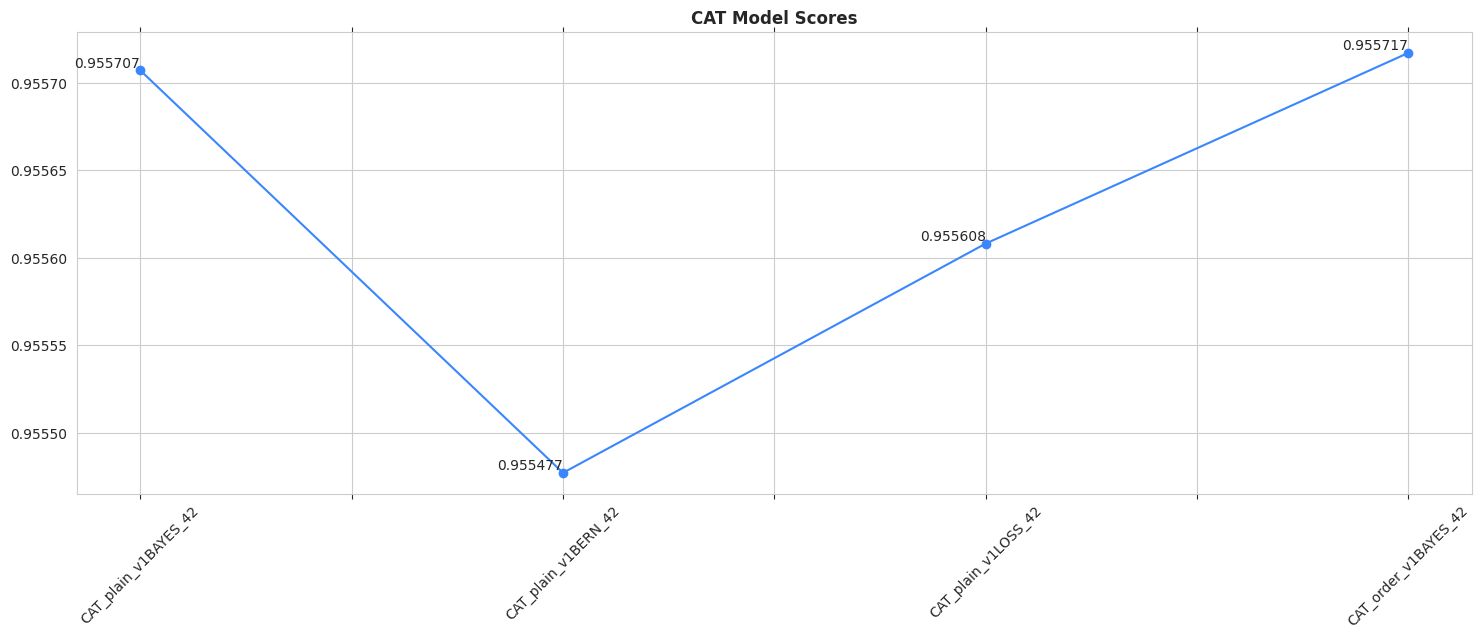

In [27]:
## -- Get Scores --
all_model_scores = {}

for k, v in all_model_predictions.items():
    for x, y in v.items():
        if x == 'score':
            # print(k, y)
            all_model_scores[k] = y

plt.figure(figsize=(18, 6))
pd.Series(all_model_scores).plot(marker='o')
plt.title('CAT Model Scores', fontweight='semibold')
for i, score in enumerate(all_model_scores.values()):
    plt.text(float(i), score+5e-6, score, ha='right', va='center_baseline')

plt.tick_params('x', rotation=45, reset=True)
plt.show()

In [28]:
## -- Get oof outputs --
all_model_oof = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'oof_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_oof = pd.concat([all_model_oof, pd.DataFrame({n: y})], axis=1)

all_model_oof.to_parquet(f"oof_{version_name}_models.parquet", index=False)
all_model_oof.head()

,CAT_plain_v1BAYES_42_955707,CAT_plain_v1BERN_42_955477,CAT_plain_v1LOSS_42_955608,CAT_order_v1BAYES_42_955717
0,0.997356,0.996361,0.996653,0.997288
1,0.008762,0.012977,0.012114,0.008878
2,0.009096,0.012251,0.010402,0.008787
3,0.050198,0.039231,0.039957,0.052065
4,0.997489,0.991030,0.997232,0.997558


In [29]:
## -- Get test predictions --
all_model_test = pd.DataFrame()

for i, (k, v) in enumerate(all_model_predictions.items()):
    for x, y in v.items():
        if x == 'test_preds':
            n = f"{k}_{str(list(all_model_scores.values())[i]).split('.')[1]}"
            all_model_test = pd.concat([all_model_test, pd.DataFrame({n: y})], axis=1)

all_model_test.to_parquet(f"test_{version_name}_models.parquet", index=False)
all_model_test.head()

,CAT_plain_v1BAYES_42_955707,CAT_plain_v1BERN_42_955477,CAT_plain_v1LOSS_42_955608,CAT_order_v1BAYES_42_955717
0,0.944083,0.951161,0.956541,0.942709
1,0.007389,0.010648,0.008129,0.007315
2,0.990172,0.988138,0.988560,0.990355
3,0.003532,0.005636,0.004617,0.003571
4,0.194870,0.175661,0.181107,0.196573


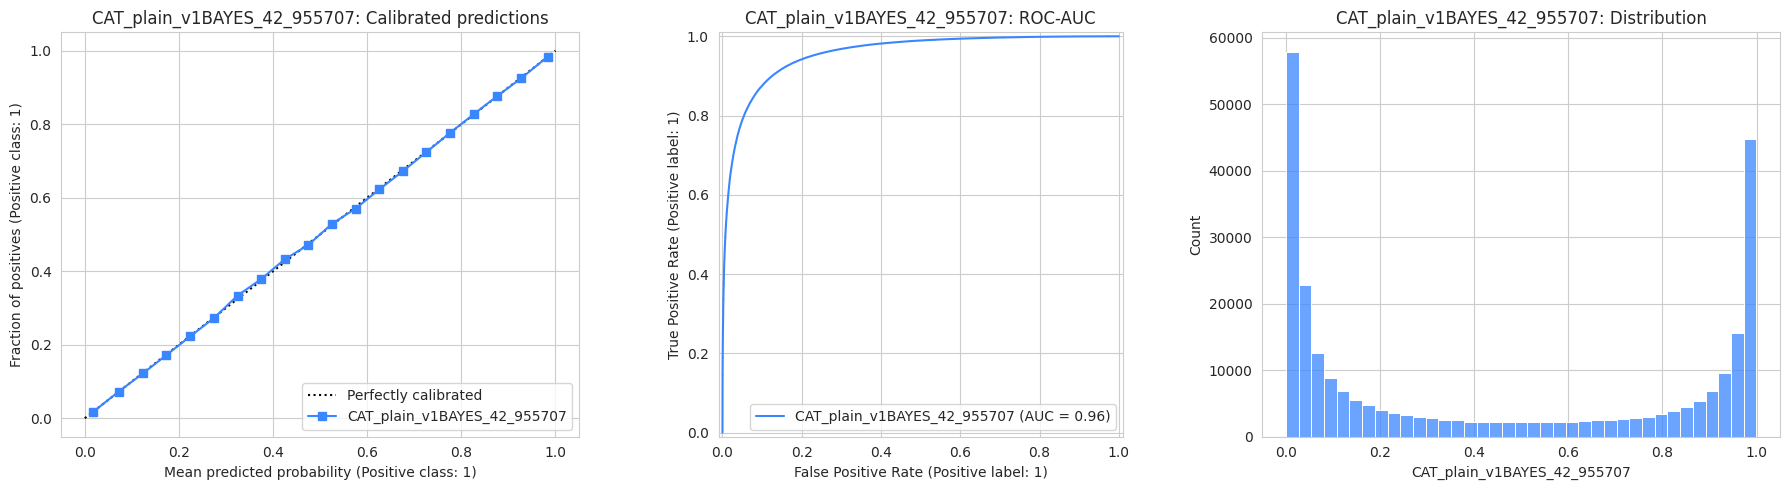

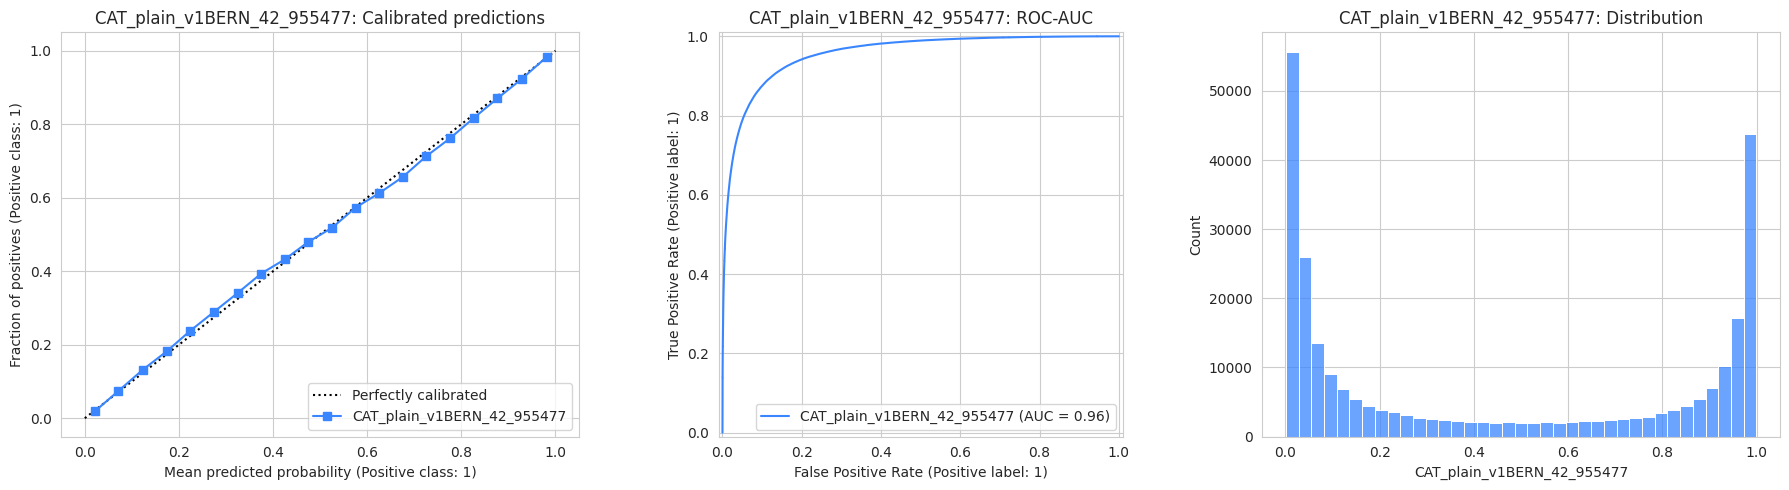

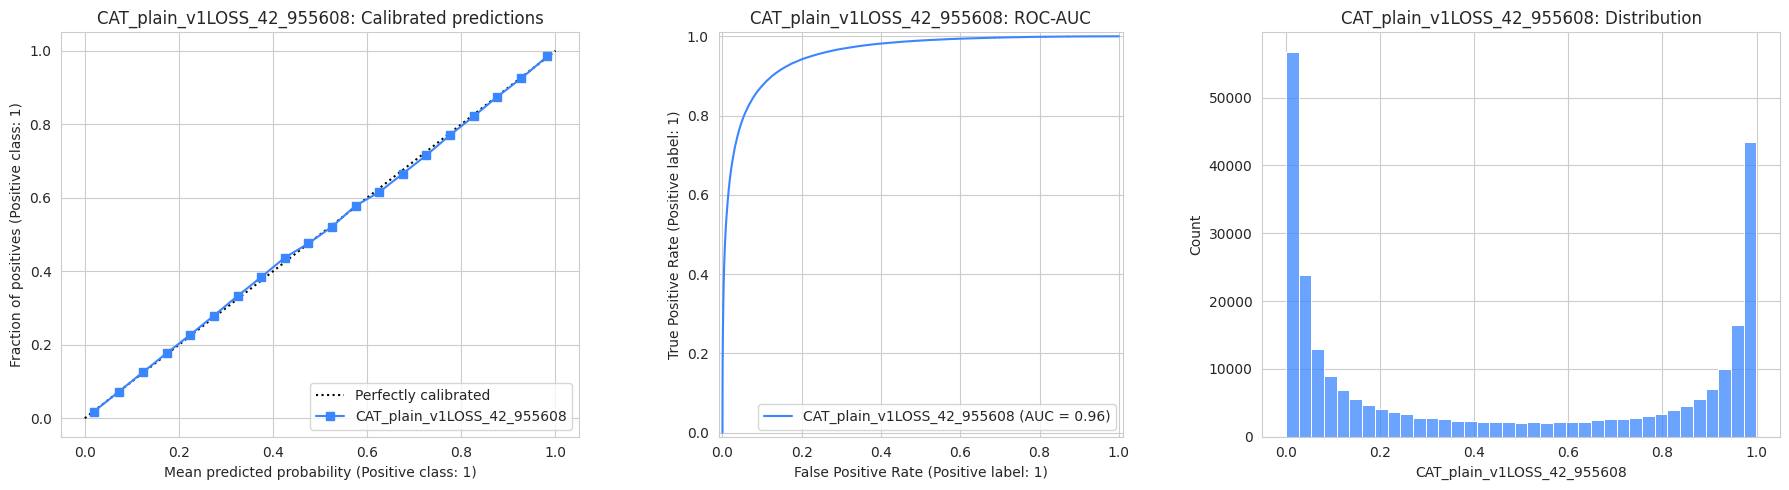

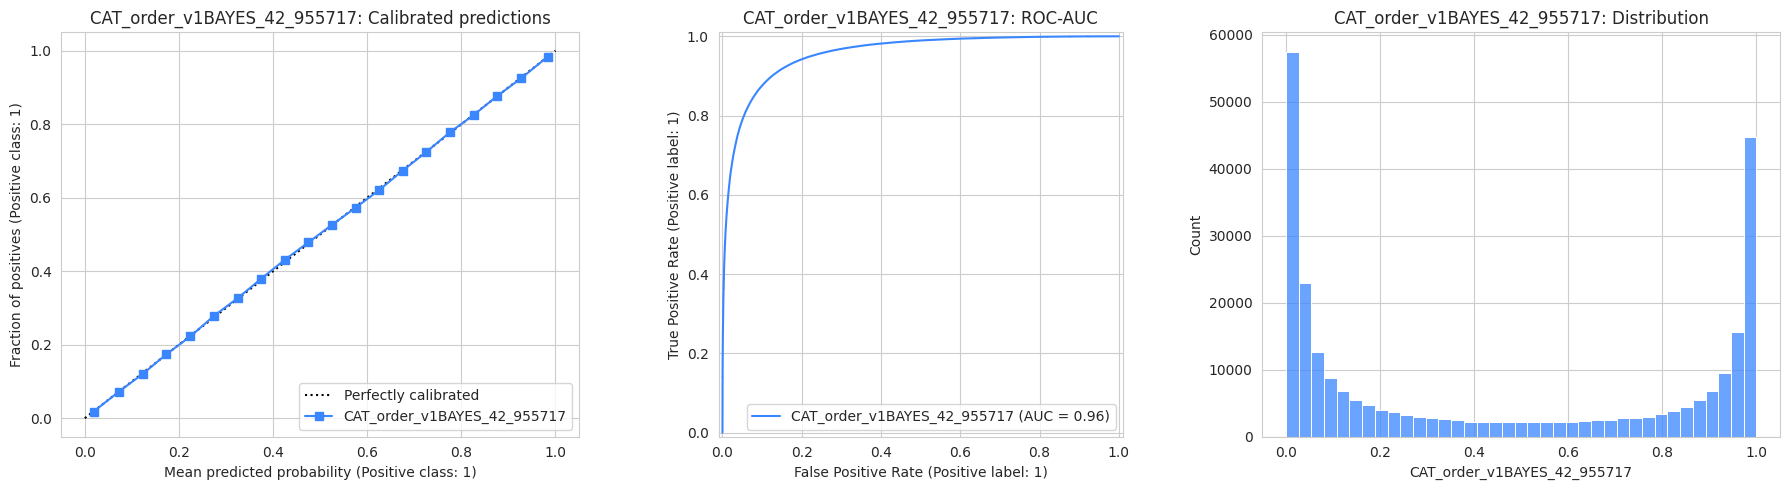

In [30]:
## -- Plot predictions --
for i, n in enumerate(all_model_test.columns):
    _, axs = plt.subplots(1, 3, figsize=(18, 5)) #, width_ratios=[0.6,0.4]

    # # Right: Confusion matrix (threshold = 0.5)
    # pred_labels = (all_model_oof[n] >= 0.5).astype('int8')
    # ConfusionMatrixDisplay.from_predictions(train[TARGET], pred_labels, cmap='Blues', colorbar=False, ax=axs[0])
    # axs[0].set_title(f"{n}: Confusion Matrix")
    # axs[0].grid(False)

    CalibrationDisplay.from_predictions(train[TARGET], all_model_oof[n], n_bins=20, name=n, ax=axs[0])
    axs[0].set_title(f"{n}: Calibrated predictions")

    # Left: ROC curve
    # score = [x for x in all_model_scores.values()][i]
    RocCurveDisplay.from_predictions(train[TARGET], all_model_oof[n], name=n, ax=axs[1])
    axs[1].set_title(f"{n}: ROC-AUC")
    # axs[1].grid(False)

    sns.histplot(all_model_test[n], ax=axs[2])
    axs[2].set_title(f"{n}: Distribution")

    plt.tight_layout()
    plt.show()
    print()

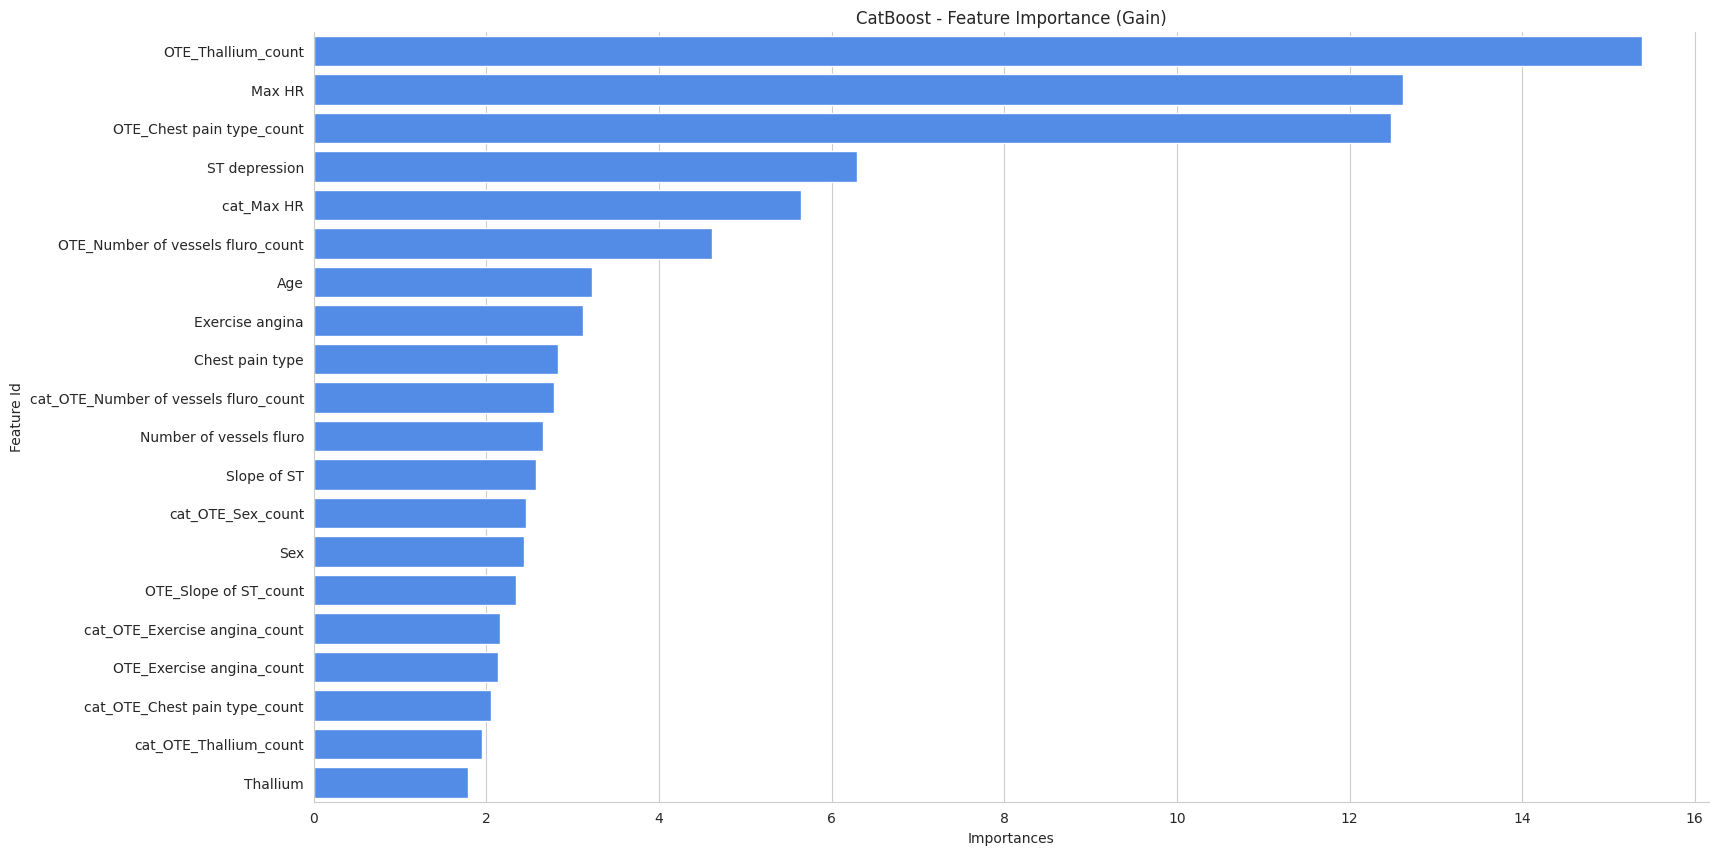

In [31]:
## -- Plot Feature Importances --
MAX = 20
get_model = all_model_predictions[list(all_model_predictions.keys())[-1]]
feature_importances = get_model['model'].get_feature_importance(prettified=True)

plt.figure(figsize=(18, 10))
ax = sns.barplot(x='Importances', y='Feature Id', data=feature_importances.head(MAX))
ax.set_title("CatBoost - Feature Importance (Gain)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.tight_layout()
plt.show()